<a id='top'></a>

[1. SQL](#sql)<br>
[2. EDA](#eda)<br>
[3. Modeling](#modeling)<br>
[4. Production](#prod)<br>
[5. Evaluation](#eval)<br>

In [ ]:
# References
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# https://www.kaggle.com/amavuduru/exploratory-data-analysis-and-logistic-regression

In [59]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from pycaret import classification
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from pycaret.classification import *
%matplotlib inline
import pyodbc
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=10.27.251.83;'
                      'Database=OpenBook;'
                      'Trusted_Connection=yes;')

<a id='sql'></a>
# SQL Query
[Top](#top)<br>

In [90]:
# For training model, declare 4 prior terms. For production model, declare current term only and leave others blank
data = pd.read_sql_query("""\
declare @term1 varchar(50) = '2023sp'
declare @term2 varchar(50) = '2022sp'
declare @term3 varchar(50) = '2021sp'
declare @term4 varchar(50) = '2020sp'

select
	t1.[student id]
	, t1.Term [Start Term]
	, [GPA Institutional Cumulative]
	, case when t2.[Student ID] is not null then 1 else 0 end [Retained]
	, case when ([start of term retention status] in ('new', 'transfer in') or [starting cohort term] = t1.term) then 1 else 0 end [new_student]
	, case when tests.[Student ID] is null then 0 else 1 end [ptest_exists]
	, max(aleks) aleks, max(sat_english) sat_english, max(sat_math) sat_math, max(act_composite) act_composite, max(cccrtw) cccrtw
	, case when max(count_tests) is null then 0 else max(count_tests) end count_tests
	, case when waiver.[Student ID] is null then 0 else 1 end test_waiver 
    , t1.[Home College] [Home_College]
	, case when t1.[Home College] = 'DA' then 1 else 0 end [HC_DA]
	, case when t1.[Home College] = 'KK' then 1 else 0 end [HC_KK]
	, case when t1.[Home College] = 'MX' then 1 else 0 end [HC_MX]
	, case when t1.[Home College] = 'OH' then 1 else 0 end [HC_OH]
	, case when t1.[Home College] = 'TR' then 1 else 0 end [HC_TR]
	, case when t1.[Home College] = 'WR' then 1 else 0 end [HC_WR]
	, case when t1.[Home College] not in ('DA', 'HW', 'KK', 'MX', 'OH', 'TR', 'WR') then 1 else 0 end [HC_other]
	, [First_reg]
	, case when t1.[Gender] = 'Male' then 1 else 0 end [Gender_Male]
	, case when t1.[Gender] = '(Blank)' then 1 else 0  end [Gender_Unknown]
	, case when [Age at Census] is null then 0 else [age at census] end [age]
	, case when t1.[Ethnicity] = 'Black' then 1 else 0 end [Eth_Black]
	, case when t1.[Ethnicity] = 'Asian' then 1 else 0 end [Eth_Asian]
	, case when t1.[Ethnicity] = 'White' then 1 else 0 end [Eth_White]
	, case when t1.[Ethnicity] not in ('Black', 'Hispanic', 'White', 'Asian') then 1 else 0 end [Eth_Other]
	, case when t1.[STAR Eligibility] = 'STR' then 1 else 0 end [Star Status]
	, case when [Declared Degree] in ('AC', 'BC') then 1 else 0 end [Deg_cert]
	, case when [Declared Degree] in ('AAS', 'AGS') then 1 else 0 end [Deg_terminal]
	, case when [Full Or Part Time] = 'Full-Time' then 1 else 0 end [FT]
	, case when [Ever Early College] is null then 0 else 1 end [Ever Early College]
	, case when t1.[Athletic Indicator] = 'no' then 0 else 1 end [Athletic Indicator]
	, case when pelig.[Student ID] is null then 0 else 1 end [Pell Eligibility Status]
--	, case when pell_recipient_status = 'Pell Recipient' then 1 else 0 end [pell recipient status]
	, case when (bridg.[student id] is not null 
        or (gwy.[Student ID] is not null 
            and ([start of term retention status] in ('new', 'transfer in') or [starting cohort term] = t1.term)))
        and t1.[home college] = 'TR' then 1 else 0 end [Gateway/Bridge status]

from
	openbook.dbo.pvt_studentterms t1
	
left join /*Exclude completers*/
(select distinct [Student ID], [Term Order]
from openbook.dbo.pvt_studentdegrees) 
degree on t1.[Student ID] = degree.[Student ID] and t1.[Term Order] = degree.[Term Order]

left join /*Check subsequent term enrollment*/
(select [Student ID], [Term Order], term
from openbook.dbo.pvt_StudentTerms
where Enrolled = 'yes' and [Instructional Area] = 'Semester Credit')
t2 on t1.[Student ID] = t2.[Student ID] and t1.[Term Order] = (t2.[Term Order] - 99)

/*Registration Date*/
left join
(select colleagueid, term, min([first_reg]) [First_reg] from (
	(select colleagueid, term, datediff(day, startDate, statusdate) [First_reg] from openbook.dbo.tbl_dropadd da
		left join (select  classsection, startdate from openbook.dbo.tbl_classsections) sd on da.classSection = sd.classSection
	where [status] = 'E' and academicLevel = 'cred' group by [colleagueId], term, startdate, statusdate)) reg2
group by colleagueid, term)
reg on t1.[student id] = reg.colleagueid and t1.term = reg.term

/*Early College*/
left join
(select distinct [student id], [Ever Early College] = 'Was EC' from openbook.dbo.pvt_studentterms where [enrolled] = 'yes' and [Early College] = 'yes') 
ec on t1.[Student ID] = ec.[Student id]

/*Placement test scores and count of tests*/
left join
(select [student id], [SAT - New - Evidence Based Read & Writing] sat_english, [SAT - New - Math Section Score SAT] sat_math, [CCCRTW - Writing] cccrtw
	, [ACT - Composite] act_composite, [ALEKS PPL - Math] aleks, count_tests, [term taken order]
from  
	(select [student id], test, [high score], [term taken order], row_number() over (partition by [student id] order by [term taken order]) count_tests
	from openbook.dbo.pvt_studenttests
	where [test] in ('CCCRTW - Writing', 'ACT - Composite', 'ALEKS PPL - Math') or ([test category] in ('sat') and [high score] >=100))
	sourcetable
	PIVOT
	(max([high score])
	for test IN ([SAT - New - Evidence Based Read & Writing], [SAT - New - Math Section Score SAT], [CCCRTW - Writing], [ACT - Composite], [ALEKS PPL - Math])) pivottable) 
tests on t1.[student id] = tests.[Student ID] and t1.[Term Order] >= tests.[term taken order]

/*Placement test waiver*/
left join
(select [student id], min([term taken order]) [term taken order] from openbook.dbo.pvt_studenttests 
where [test category] = 'placement test waiver' group by [student id])-- and concat(left(@term1, 4), 02) >= [term taken order])
waiver on t1.[student id] = waiver.[Student ID] and t1.[term order] >= waiver.[term taken order]

/*Student Financials: Pell eligible, Pell recipient, checklist items, DEL holds*/
left join
(select distinct [Student ID], [Financial Aid Federal ID], [Financial Aid Year]
from [Openbook].[dbo].[pvt_StudentFinancialAids] 
where  [Financial Aid Federal ID] = 'PELL' and [financial aid pell candidacy] = 'yes') 
pelig on t1.[Student ID] = pelig.[student id] and left(t1.Term, 4) = pelig.[financial aid year]

/*Gateway/Bridge students for Truman*/
left join 
(select distinct [student id] from openbook.dbo.vw_ccc_pvt_ServiceIndicator 
where [Service Indicator Reason] IN ('bridg') and term = @term1)
bridg on t1.[student id] = bridg.[Student ID] 

left join 
(select distinct [student id] from openbook.dbo.vw_ccc_pvt_ServiceIndicator 
where [Service Indicator Reason] IN ('gw1', 'gwy') and term = @term1)
gwy on t1.[student id] = gwy.[Student ID] 

where
	t1.Term in (@term1, @term2, @term3, @term4)
	and Enrolled = 'yes' and [Instructional Area] = 'semester credit' 
	and degree.[Student ID] is null and [Early College] = 'no' and [declared degree] not in ('na')
    and [Academic Plan] not in ('Communications Technology-AAS', 'Electric Construction Tech-AAS')
group by t1.[student id], t2.[Student ID], [start of term retention status], tests.[Student ID], waiver.[Student ID], t1.Term, t1.[Home College]
	, [First_reg], t1.[Gender], [age at census], t1.Ethnicity, t1.[STAR Eligibility], [Declared Degree], [Full or Part Time], [Ever Early College]
	, t1.[Athletic Indicator], pelig.[Student ID], [Starting Cohort Term], [GPA Institutional Term], gwy.[Student ID], bridg.[Student ID], gwy.[Student ID]
    , [gpa institutional cumulative]
order by [student id], [Start Term]

""", conn)

<AxesSubplot:xlabel='max_placement_score', ylabel='GPA Institutional Cumulative'>

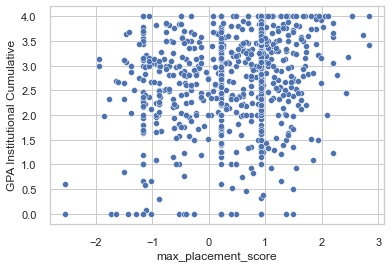

In [91]:
# Feature engineering placement tests to get normalized highest placement test score
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(data[['aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw']])
sc_X = pd.DataFrame(data=sc_X, columns=['aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled'])
data_scaled = pd.concat([data, sc_X], axis = 1)
data_scaled['max_placement_score'] = data_scaled[['aleks_scaled','sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled']].max(axis=1)

# For training data - wanted to see relationship between placement test score (scaled) and term GPA
sampledf = data_scaled.sample(n=1000)
sns.scatterplot(x = sampledf['max_placement_score'], y = sampledf['GPA Institutional Cumulative'])

In [92]:
data_prior = pd.DataFrame(data_scaled[data_scaled['Start Term'].isin(['2022SP', '2020SPS', '2021SP'])].reset_index(drop = True))
data_current = pd.DataFrame(data_scaled[data_scaled['Start Term'] == '2023SP'].reset_index(drop = True))
print(data_prior.shape)
print(data_current.shape)

(32783, 43)
(16464, 43)


<a id='eda'></a>

# EDA
[Top](#top)<br>

In [ ]:
# Variables to test include:

# new or continuing student
# placement tests
# waived out of placement test
# home college (DA, KK, MX, OH, TR, WR, other, ref = HW)
# first reg date
# gender (male, other, ref = female)
# age
# ethnicity (black, asian, white, other, ref = hispanic)
# star status (free tuition)
# degree (certificate, terminal, coursetaker, ref=transfer)
# full time status
# ever early college
# athletic indicator
# pell eligibility status

In [26]:
data_scaled.describe()

,GPA Institutional Cumulative,Retained,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,cccrtw,count_tests,test_waiver,HC_DA,HC_KK,HC_MX,HC_OH,HC_TR,HC_WR,HC_other,First_reg,Gender_Male,Gender_Unknown,age,Eth_Black,Eth_Asian,Eth_White,Eth_Other,Star Status,Deg_cert,Deg_terminal,FT,Ever Early College,Athletic Indicator,Pell Eligibility Status,Gateway/Bridge status,aleks_scaled,sat_english_scaled,sat_math_scaled,act_composite_scaled,cccrtw_scaled,max_placement_score
count,32201.000000,32783.000000,32783.000000,32783.000000,23787.000000,5165.000000,5119.000000,2296.000000,20202.000000,32783.000000,32783.00000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.0,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,32783.000000,2.378700e+04,5.165000e+03,5.119000e+03,2.296000e+03,2.020200e+04,27475.000000
mean,2.748879,0.624348,0.115151,0.838087,45.502585,506.416263,499.552647,18.689460,4.734997,2.258488,0.07452,0.095232,0.052009,0.254126,0.048562,0.106763,0.220663,0.0,-37.798463,0.369673,0.001708,25.122564,0.285575,0.060275,0.121953,0.030504,0.159168,0.042888,0.351188,0.400634,0.117622,0.005796,0.519812,0.000336,6.213179e-17,-2.201100e-16,-7.773079e-17,-5.570457e-17,1.519426e-16,0.478564
std,0.901325,0.484298,0.319209,0.368377,22.357065,84.012657,88.728894,4.080112,1.410206,1.638950,0.26262,0.293540,0.222048,0.435375,0.214953,0.308816,0.414700,0.0,28.010682,0.482724,0.041296,8.533911,0.451695,0.238000,0.327237,0.171971,0.365838,0.202608,0.477349,0.490035,0.322165,0.075910,0.499615,0.018315,1.000021e+00,1.000097e+00,1.000098e+00,1.000218e+00,1.000025e+00,0.873482
min,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,200.000000,8.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-166.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.035309e+00,-3.647616e+00,-3.376374e+00,-2.620464e+00,-3.357747e+00,-3.357747
25%,2.270000,0.000000,0.000000,1.000000,29.000000,440.000000,440.000000,16.000000,3.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-59.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.381529e-01,-7.906272e-01,-6.712409e-01,-6.593069e-01,-1.230345e+00,0.117756
50%,2.880000,1.000000,0.000000,1.000000,44.000000,510.000000,510.000000,18.000000,5.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-33.000000,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-6.720994e-02,4.266123e-02,1.177562e-01,-1.690175e-01,1.879230e-01,0.756908
75%,3.410000,1.000000,0.000000,1.000000,63.000000,570.000000,560.000000,21.000000,6.000000,3.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,-14.000000,1.000000,0.000000,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,7.826512e-01,7.569085e-01,6.813255e-01,5.664167e-01,8.970570e-01,0.897057
max,4.000000,1.000000,1.000000,1.000000,100.000000,790.000000,800.000000,35.000000,6.000000,14.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,28.000000,1.000000,1.000000,121.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.437644e+00,3.375815e+00,3.386458e+00,3.998443e+00,8.970570e-01,3.998443


In [27]:
# see which variables might show large variation between retained/not retained
data_scaled.groupby('Retained').mean()

,GPA Institutional Cumulative,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,cccrtw,count_tests,test_waiver,HC_DA,HC_KK,HC_MX,HC_OH,HC_TR,HC_WR,HC_other,First_reg,Gender_Male,Gender_Unknown,age,Eth_Black,Eth_Asian,Eth_White,Eth_Other,Star Status,Deg_cert,Deg_terminal,FT,Ever Early College,Athletic Indicator,Pell Eligibility Status,Gateway/Bridge status,aleks_scaled,sat_english_scaled,sat_math_scaled,act_composite_scaled,cccrtw_scaled,max_placement_score
Retained,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,2.442418,0.134389,0.805765,44.105713,501.317221,493.250304,18.815870,4.693148,2.114332,0.082663,0.103532,0.063419,0.251076,0.063013,0.099635,0.194803,0.0,-34.190256,0.390093,0.001786,25.437109,0.322696,0.049614,0.123914,0.033212,0.113601,0.053837,0.346650,0.330329,0.102720,0.006902,0.51011,0.000000,-0.022023,-0.039918,-0.027822,-0.004311,-0.025126,0.448283
1.0,2.928640,0.103576,0.857534,46.285274,508.820513,502.539591,18.594821,4.758588,2.345222,0.069621,0.090238,0.045144,0.255961,0.039867,0.111051,0.236222,0.0,-39.969416,0.357387,0.001661,24.933311,0.263240,0.066689,0.120774,0.028874,0.186584,0.036301,0.353918,0.442935,0.126588,0.005130,0.52565,0.000537,-0.019930,-0.054098,-0.015742,-0.038055,0.009238,0.468479


<AxesSubplot:>

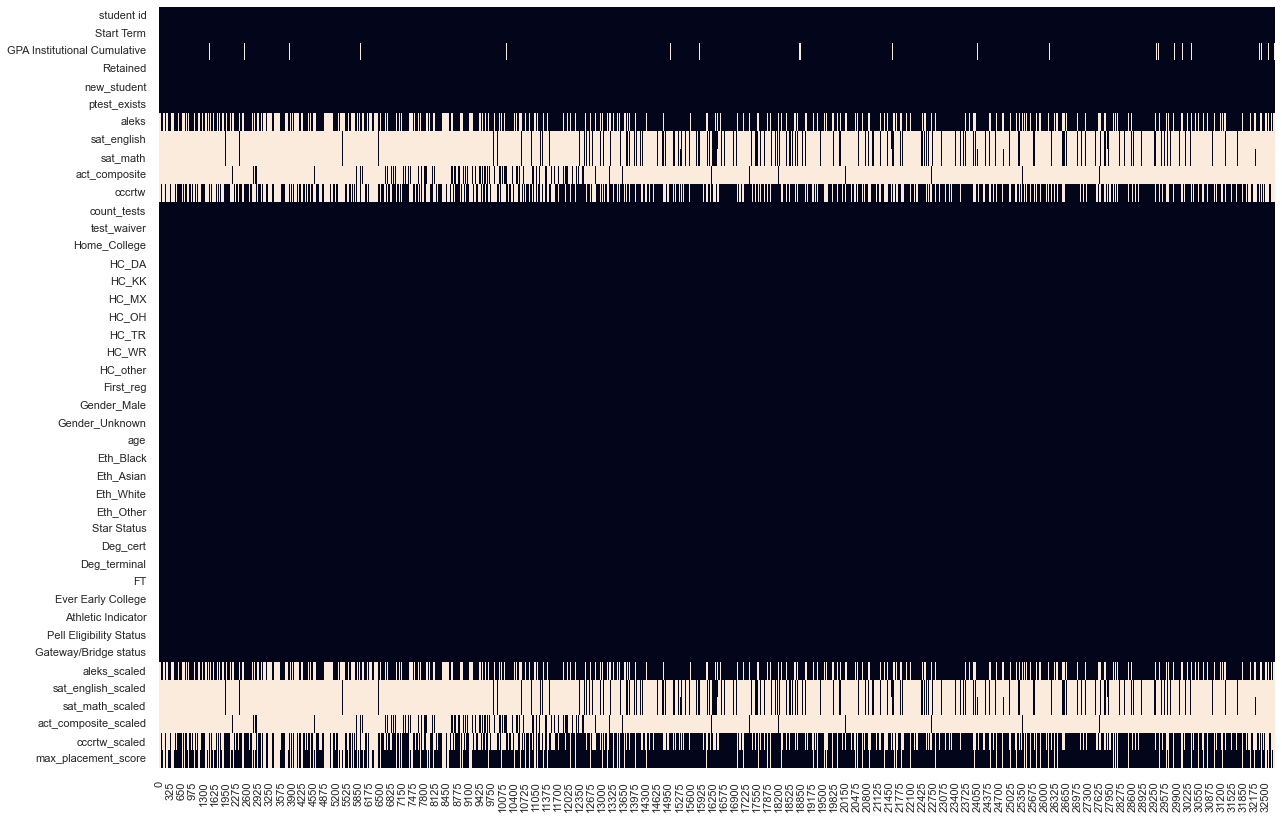

In [45]:
# check for null values
plt.figure(figsize=(20,14))
sns.heatmap(data_scaled.isnull().T, cbar = False)

<AxesSubplot:xlabel='Retained', ylabel='count'>

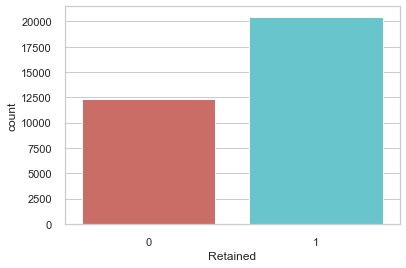

In [41]:
# Visualize retained/not retained 
sns.countplot(x='Retained',data=data_prior, palette='hls')

<AxesSubplot:xlabel='count_tests', ylabel='Count'>

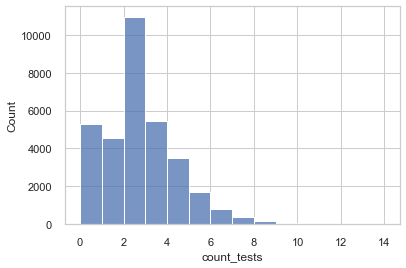

In [42]:
# view distribution for different numeric variables
sns.histplot(data = data_prior, x='count_tests', binwidth = 1)

<AxesSubplot:xlabel='ptest_exists', ylabel='count'>

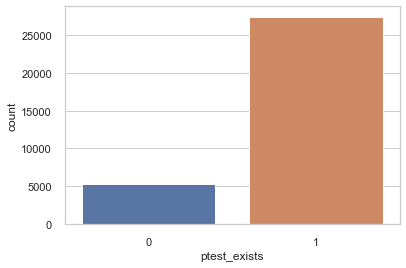

In [43]:
# view counts for categorical variables
sns.countplot(x = 'ptest_exists', data = data_prior)

<AxesSubplot:>

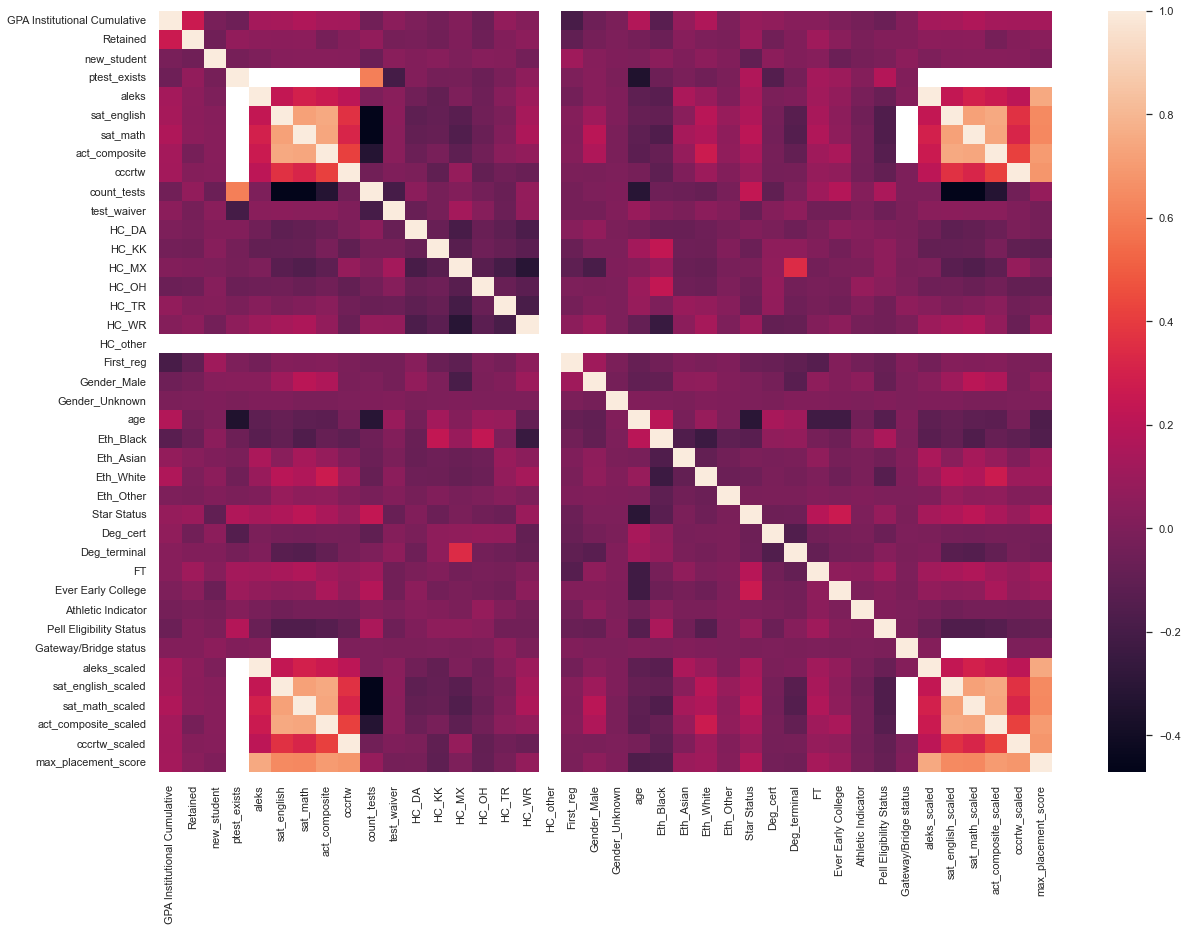

In [44]:
# Visualize correlations between data
plt.figure(figsize=(20,14))
sns.heatmap(data_scaled.corr())

<a id='modeling'></a>

# Modeling
[Top](#top)<br>

In [93]:
# Notes on pycaret classification modeling:
# data split into train/test set
# numeric/categorical features inferred (should have been correctly set up by SQL query)
# 10 fold cross validation used
# numeric imputation done using mean value, categorical done using mode
# 70/30 imbalanced data set corrected via SMOTE

from pycaret.classification import *
classification_setup = classification.setup(data= data_prior, fix_imbalance = True, target='Retained',
                                            ignore_features = ['student id', 'Start Term',
                                                           'aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw',
                                                           'aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 
                                                            'act_composite_scaled', 'cccrtw_scaled', 'Gateway/Bridge status'
                                                              , 'Home_College']
                                            , numeric_features = ['count_tests']
                                           , normalize = True)

,Description,Value
0,session_id,1665
1,Target,Retained
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(32783, 43)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,23
8,Ordinal Features,False
9,High Cardinality Features,False


In [97]:
# get_config('X_train').to_clipboard()

In [94]:
# tests different sklearn classification models to determine high performers
classification.compare_models(include = ['lightgbm', 'xgboost', 'gbc', 'catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6768,0.6937,0.8380,0.7021,0.7640,0.2637,0.2743,9.0320
lightgbm,Light Gradient Boosting Machine,0.6727,0.6918,0.8158,0.7058,0.7568,0.2641,0.2707,2.5770
xgboost,Extreme Gradient Boosting,0.6685,0.6773,0.8216,0.6998,0.7558,0.2500,0.2580,2.9110
gbc,Gradient Boosting Classifier,0.6638,0.6907,0.7698,0.7141,0.7408,0.2641,0.2657,2.2210


In [95]:
# use highest performer
created_model = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6841,0.6934,0.8325,0.7110,0.7670,0.2861,0.2948
1,0.6697,0.6840,0.8507,0.6914,0.7628,0.2377,0.2520
2,0.6780,0.6949,0.8423,0.7017,0.7656,0.2647,0.2762
3,0.6754,0.6882,0.8423,0.6993,0.7642,0.2576,0.2694
4,0.6662,0.6929,0.8311,0.6945,0.7567,0.2388,0.2488
5,0.6837,0.6942,0.8381,0.7086,0.7679,0.2821,0.2921
6,0.6754,0.7021,0.8416,0.6995,0.7640,0.2580,0.2696
7,0.6871,0.7039,0.8416,0.7107,0.7706,0.2897,0.3001
8,0.6805,0.7045,0.8345,0.7067,0.7653,0.2756,0.2851


In [96]:
tuned_model = tune_model(created_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6797,0.6990,0.8262,0.7090,0.7631,0.2776,0.2855
1,0.6763,0.6940,0.8472,0.6985,0.7657,0.2574,0.2703
2,0.6806,0.6949,0.8325,0.7076,0.7650,0.2768,0.2858
3,0.6688,0.6931,0.8262,0.6985,0.7570,0.2485,0.2573
4,0.6749,0.6953,0.8339,0.7017,0.7621,0.2609,0.2707
5,0.6710,0.6958,0.8158,0.7042,0.7559,0.2598,0.2665
6,0.6784,0.7020,0.8311,0.7060,0.7635,0.2717,0.2806
7,0.6941,0.7070,0.8472,0.7154,0.7757,0.3055,0.3165
8,0.6870,0.7028,0.8352,0.7128,0.7691,0.2927,0.3016


In [82]:
# review model metrics
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

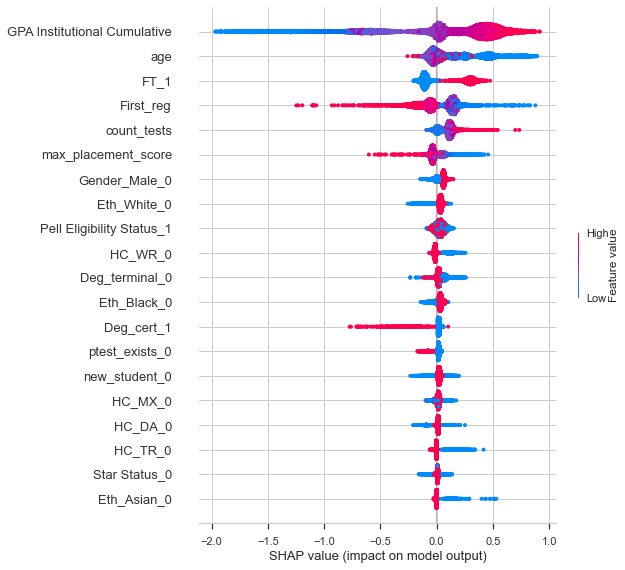

In [103]:
interpret_model(tuned_model)

In [107]:
get_config('X_test').head(n=1)

,GPA Institutional Cumulative,count_tests,First_reg,age,max_placement_score,new_student_0,ptest_exists_0,test_waiver_0,HC_DA_0,HC_KK_0,...,Eth_Asian_0,Eth_White_0,Eth_Other_1,Star Status_0,Deg_cert_1,Deg_terminal_0,FT_1,Ever Early College_1,Athletic Indicator_1,Pell Eligibility Status_1
17536,1.090042,0.44865,0.59843,-0.598786,0.156505,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


In [106]:
interpret_model(tuned_model, plot = 'reason', observation = 0)

In [108]:
# create final model to be used on current term data
final_model = finalize_model(tuned_model)
save_model(final_model, 'sp23_retention_model_20230113')

<a id='eval'></a>

# Evaluation of Training results vs Production
[Top](#top)<br>

- Evaluation metrics for testing data vs. actual outcome
- Calibration curve of test v actual
- Brier score of test v actual

In [99]:
### Evaluation Metrics: Accuracy, AUC, Precision/Recall, confusion matrix
# Test set
current_set = predict_model(final_model, raw_score = True, data = data_scaled)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7753,0.8061,0.9076,0.7984,0.8495,0.4132,0.4267


In [180]:
### Evaluation Metrics: Accuracy, AUC, Precision/Recall, confusion matrix
# 2022FA
current_set = predict_model(final_model, raw_score = True, data = data_scaled)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['student id',
                                                       'Start Term', 'aleks',
                                                       'sat_english',
                                                       'sat_math',
                                                       'act_composite',
                                                       'cccrtw', 'aleks_scaled',
                                                       'sat_english_scaled',
                                                       'sat_math_scaled',
                                                       'act_composite_scaled',
                                                       'cccrtw_scaled'],
                 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7174,0.7516,0.8727,0.7417,0.8019,0.3205,0.3337


### Confusion Matrix for training set vs. current data
#### Training set
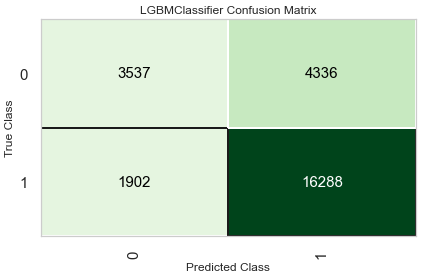
#### 2022FA


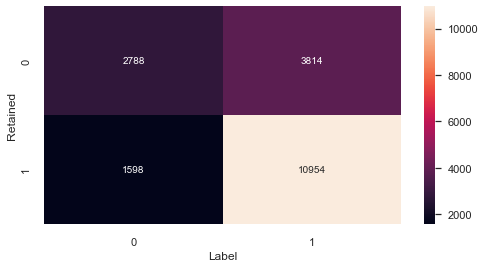

In [181]:
plt.figure(figsize=(8, 4))
sns.heatmap(pd.crosstab(current_set['Retained'], current_set['Label']), annot = True, fmt ='0')
plt.show()

### Calibration Curve
#### Training set
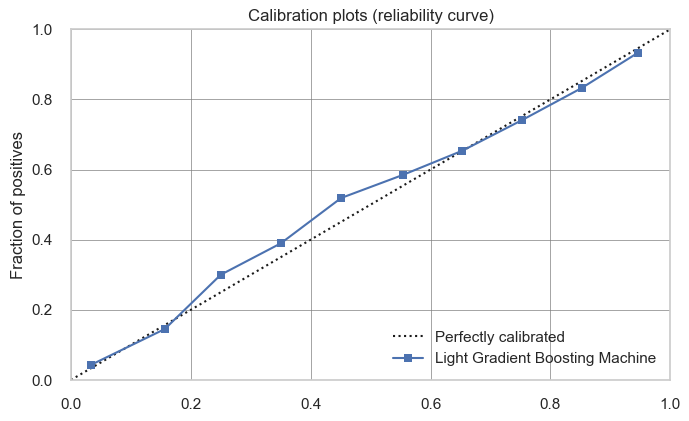
#### 2022FA

In [182]:
# First, sort the dataframe by the 'Score' column
current_set.sort_values(by='Score_1', inplace=True)

# Create bins of equal size
bins = np.linspace(min(current_set['Score_1']), max(current_set['Score_1']), 10)

# Create a new column for the binned scores
current_set['Score_Binned'] = pd.cut(current_set['Score_1'], bins)

# Calculate the average score for each bin
bin_avg = current_set.groupby('Score_Binned').mean()['Retained']
bin_avg_predicted = current_set.groupby('Score_Binned').mean()['Score_1']
print(bin_avg)
print(bin_avg_predicted)

Score_Binned
(0.0079, 0.117]    0.119760
(0.117, 0.225]     0.246358
(0.225, 0.334]     0.341693
(0.334, 0.443]     0.420094
(0.443, 0.551]     0.493234
(0.551, 0.66]      0.576658
(0.66, 0.769]      0.674072
(0.769, 0.877]     0.786472
(0.877, 0.986]     0.907972
Name: Retained, dtype: float64
Score_Binned
(0.0079, 0.117]    0.072696
(0.117, 0.225]     0.182331
(0.225, 0.334]     0.281571
(0.334, 0.443]     0.386873
(0.443, 0.551]     0.499979
(0.551, 0.66]      0.609407
(0.66, 0.769]      0.717723
(0.769, 0.877]     0.823427
(0.877, 0.986]     0.924161
Name: Score_1, dtype: float64


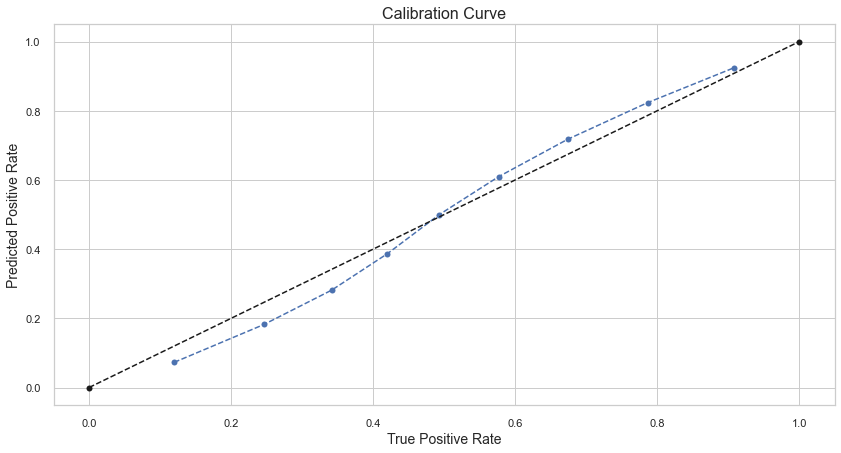

In [183]:
plt.figure(figsize=(14,7))

# Plot calibration curve
plt.plot(bin_avg, bin_avg_predicted, marker='o', linestyle='--', color='b')

# Plot reference line
plt.plot([0, 1], [0, 1], marker='o', linestyle='--', color='k')

# Add labels
plt.xlabel('True Positive Rate', fontsize=14)
plt.ylabel('Predicted Positive Rate', fontsize=14)

# Add title
plt.title('Calibration Curve', fontsize=16)

# Add legend
plt.legend(loc="lower right", fontsize=14)

plt.show()